In [1]:
from typing import Annotated, Any, Sequence
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display


### 병렬 노드

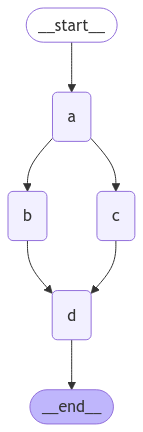

In [37]:
class State(TypedDict):
    aggregate: Annotated[list, add_messages]


class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret
    
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}

builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [3]:
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='1aa6441f-5593-4b8e-b71f-602626193b33')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='1aa6441f-5593-4b8e-b71f-602626193b33')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='1aa6441f-5593-4b8e-b71f-602626193b33'), HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='78aed7bd-2e9e-4f00-9b87-f2f0a28988f0'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='28554773-dace-4b04-85a5-32f5714f621d')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='1aa6441f-5593-4b8e-b71f-602626193b33'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='78aed7bd-2e9e-4f00-9b87-f2f0a28988f0'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='28554773-dace-4b04-85a5-32f5714f621d'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='0078f69a-4fa5-4694-910c-b383e0c5c530')]}

### 예외

In [53]:
from langgraph.pregel import RetryPolicy

RetryPolicy().__annotations__

{'initial_interval': float,
 'backoff_factor': float,
 'max_interval': float,
 'max_attempts': int,
 'jitter': bool,
 'retry_on': typing.Union[typing.Type[Exception], typing.Sequence[typing.Type[Exception]], typing.Callable[[Exception], bool]]}

In [ ]:
builder.add_node(
    "a",
    print,
    retry=RetryPolicy(),
)

### 추가 단계

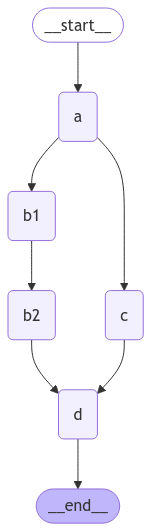

In [4]:
builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b1", ReturnNodeValue("I'm B1"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_edge("a", "b1")
builder.add_edge("a", "c")
builder.add_edge("b1", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [5]:
graph.invoke({"aggregate": []})


Adding I'm A to []
Adding I'm B1 to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='0d66754e-1ac5-4e5e-8073-8f26930bc53b')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='0d66754e-1ac5-4e5e-8073-8f26930bc53b')]
Adding I'm B2 to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='0d66754e-1ac5-4e5e-8073-8f26930bc53b'), HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='7094764d-370f-443c-bb13-732aa25cc969'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='20263e3f-b8cd-4758-b37a-a786ee0c5a42')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='0d66754e-1ac5-4e5e-8073-8f26930bc53b'), HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='7094764d-370f-443c-bb13-732aa25cc969'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='20263

{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='0d66754e-1ac5-4e5e-8073-8f26930bc53b'),
  HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='7094764d-370f-443c-bb13-732aa25cc969'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='20263e3f-b8cd-4758-b37a-a786ee0c5a42'),
  HumanMessage(content="I'm B2", additional_kwargs={}, response_metadata={}, id='029ad901-3a5c-43a1-a7de-03770439a4b8'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='eb159133-f7d8-4943-9f2d-9a1f2df0e5bd')]}

### conditional branching

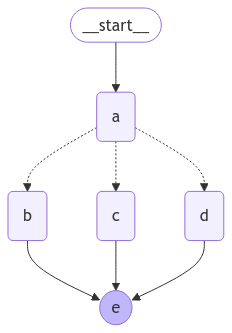

In [29]:
class State1(State):
    which: str


class ReturnNodeValue1:
    def __init__(self, node_secret: str):
        self._value = node_secret
    
    def __call__(self, state: State1) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}
    
def route_bc_or_cd(state: State1) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


builder = StateGraph(State1)
builder.add_node("a", ReturnNodeValue1("I'm A"))
builder.add_node("b", ReturnNodeValue1("I'm B"))
builder.add_node("c", ReturnNodeValue1("I'm C"))
builder.add_node("d", ReturnNodeValue1("I'm D"))
builder.add_node("e", ReturnNodeValue1("I'm E"))

builder.add_edge(START, "a")
intermediates = ["b", "c", "d"]

builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
    then="e",
)
# builder.add_conditional_edges(
#     "a",
#     route_bc_or_cd,
#     intermediates
# )
# for node in intermediates:
#     builder.add_edge(node, "e")
# builder.add_edge("e", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [30]:
graph.invoke({"aggregate": [], "which": "bc"})


Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='51819aff-eb2f-4cc2-bd80-7d95650c78b6')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='51819aff-eb2f-4cc2-bd80-7d95650c78b6')]
Adding I'm E to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='51819aff-eb2f-4cc2-bd80-7d95650c78b6'), HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='3b3b835f-e1ca-4371-968c-fe115242518b'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='01d33d29-c617-40b2-a580-99f2c4100c4b')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='51819aff-eb2f-4cc2-bd80-7d95650c78b6'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='3b3b835f-e1ca-4371-968c-fe115242518b'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='01d33d29-c617-40b2-a580-99f2c4100c4b'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='f8210bf7-f74f-4090-8792-d48dd3ed34d7')],
 'which': 'bc'}

In [31]:
graph.invoke({"aggregate": [], "which": "cd"})


Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='6150574f-7667-4710-90d5-9eb9df0b10f6')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='6150574f-7667-4710-90d5-9eb9df0b10f6')]
Adding I'm E to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='6150574f-7667-4710-90d5-9eb9df0b10f6'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='1a82e86c-168b-4922-bdb9-1006fc021b92'), HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='db13fa6e-8481-4724-832b-6f9c7662c4ce')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='6150574f-7667-4710-90d5-9eb9df0b10f6'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='1a82e86c-168b-4922-bdb9-1006fc021b92'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='db13fa6e-8481-4724-832b-6f9c7662c4ce'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='db9b2f2d-fa06-4cd9-a8e6-f9b3f8bd0f0f')],
 'which': 'cd'}

### reliability condition

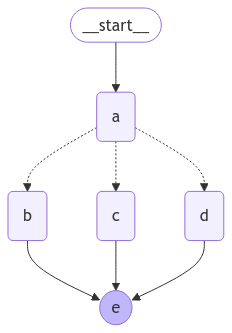

In [33]:
def reduce_fanouts(left, right):
    if left is None:
        left = []
    if not right:
        return []
    return left + right


class State(TypedDict):
    aggregate: Annotated[list, add_messages]
    fanout_values: Annotated[list, reduce_fanouts]
    which: str


class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret
    
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


class ParallelReturnNodeValue:
    def __init__(
        self,
        node_secret: str,
        reliability: float,
    ):
        self._value = node_secret
        self._reliability = reliability

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']} in parallel.")
        # e에서 신뢰도에 따라 정렬할 거라서 여기서 aggregate는 반환 안함;;
        return {
            "fanout_values": [
                {
                    "value": [self._value],
                    "reliability": self._reliability,
                }
            ]
        }

builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")

builder.add_node("b", ParallelReturnNodeValue("I'm B", reliability=0.1))
builder.add_node("c", ParallelReturnNodeValue("I'm C", reliability=0.9))
builder.add_node("d", ParallelReturnNodeValue("I'm D", reliability=0.5))


def aggregate_fanout_values(state: State) -> Any:
    ranked_values = sorted(
        state["fanout_values"], key=lambda x: x["reliability"], reverse=True
    )
    print(ranked_values)
    return {
        "aggregate": [x["value"][0] for x in ranked_values] + ["I'm E"],
        "fanout_values": [],
    }


# 집계 노드 추가
builder.add_node("e", aggregate_fanout_values)


# 상태에 따른 조건부 라우팅 로직 구현
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


# 중간 노드들 설정 및 조건부 엣지 추가
intermediates = ["b", "c", "d"]
builder.add_conditional_edges("a", route_bc_or_cd, intermediates, then="e")

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [34]:
graph.invoke({"aggregate": [], "which": "bc", "fanout_values": []})


Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='024d78e6-151e-4b39-8cb6-851a3424b356')] in parallel.
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='024d78e6-151e-4b39-8cb6-851a3424b356')] in parallel.
[{'value': ["I'm C"], 'reliability': 0.9}, {'value': ["I'm B"], 'reliability': 0.1}]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='024d78e6-151e-4b39-8cb6-851a3424b356'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='4686dbfb-a7d1-4c7a-9c8a-e29373c8a699'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='354fdf74-cd7d-4ebc-9e9a-c4a37a9b83ce'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='51acb8f9-5262-423e-aa1a-9c1b1b5adbdc')],
 'fanout_values': [],
 'which': 'bc'}

In [36]:
graph.invoke({"which": "cd"})


Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='b1bcefeb-10ed-4e68-b68c-4608279b817e')] in parallel.
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='b1bcefeb-10ed-4e68-b68c-4608279b817e')] in parallel.
[{'value': ["I'm C"], 'reliability': 0.9}, {'value': ["I'm D"], 'reliability': 0.5}]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='b1bcefeb-10ed-4e68-b68c-4608279b817e'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='3c721aee-7579-46cf-9c8a-828def1f2ea5'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='27a72aba-af70-4744-be7e-f7fdcc3d9354'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='ca04415d-8417-453d-8461-255e732da32a')],
 'fanout_values': [],
 'which': 'cd'}